In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
file_path = "/content/Commodities Data thru 18May23.xlsx"
xls = pd.ExcelFile(file_path)
df_returns = xls.parse("Return Indices")
df_returns.rename(columns={df_returns.columns[0]: "Date"}, inplace=True)
df_returns["Date"] = pd.to_datetime(df_returns["Date"])
df_returns.dropna(how="all", subset=df_returns.columns[1:], inplace=True)


df_returns.info()
df_returns.head()

 ## Summary Statistics

In [4]:
summary_stats = []


for col in df_returns.columns[1:]:
    series = df_returns[["Date", col]].dropna()
    stats = {
        "Asset": col,
        "First Date": series["Date"].min().strftime("%Y-%m-%d"),
        "N Observations": series.shape[0],
        "Mean": series[col].mean(),
        "Std Dev": series[col].std(),
        "Min": series[col].min(),
        "Max": series[col].max()
    }
    summary_stats.append(stats)


summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values("Asset").reset_index(drop=True)
summary_df.round(4)

,Asset,First Date,N Observations,Mean,Std Dev,Min,Max
0,BRENT CRUDE FUTR Jul23,1988-06-24,9105,1221.0314,952.1648,72.4409,4911.5486
1,COCOA FUTURE Jul23,1969-01-01,14187,308.6510,387.4765,39.0384,2005.8958
2,COFFEE 'C' FUTURE Jul23,1972-08-23,13237,270.5678,239.5708,22.1383,1406.7098
3,COPPER FUTURE Jul23,1988-12-07,8987,204.6554,111.9343,64.3210,468.7107
4,CORN FUTURE Jul23,1969-01-01,14187,84.1926,67.8873,9.7221,330.0101
5,COTTON NO.2 FUTR Jul23,1969-01-01,14187,128.9587,85.4314,23.8937,427.0801
6,GASOLINE RBOB FUT Jun23,2005-10-04,4598,160.2831,78.0903,38.5346,474.8832
7,GOLD 100 OZ FUTR Aug23,1975-01-03,12620,77.9636,38.2161,25.2463,327.7373
8,HEATING OIL,1986-07-01,9623,1257.2557,914.3960,86.0097,4574.4526
9,LEAN HOGS FUTURE Jul23,1986-04-02,9687,125.2390,102.5341,6.1076,382.8472


### 🔍 Insights from Summary Statistics

-  **Most volatile assets**:
  - `BRENT CRUDE FUTR`: std = 952.16  
  - `HEATING OIL`: std = 914.39  
  - `WTI CRUDE FUTR`: std = 484.08  

-  **Least volatile assets**:
  - `LME ALUMINIUM`, `SILVER FUTURE`, `NATURAL GAS FUTR`

-  **Longest history**:
  - Most assets start from **1969-01-01**


## Commodity Market Factor (Equal-weighted)

In [5]:
df_returns_pct = df_returns.copy()
df_returns_pct.iloc[:, 1:] = df_returns_pct.iloc[:, 1:].pct_change() * 100
df_returns_pct["Market Factor"] = df_returns_pct.iloc[:, 1:].mean(axis=1)

df_market_returns = df_returns_pct[["Date", "Market Factor"]].dropna()

df_market_returns["Cumulative Return"] = (1 + df_market_returns["Market Factor"] / 100).cumprod()

df_market_returns.head()


,Date,Market Factor,Cumulative Return
1,1969-01-02,0.360726,1.003607
2,1969-01-03,0.063702,1.004247
3,1969-01-06,-0.477232,0.999454
4,1969-01-07,-0.576175,0.993695
5,1969-01-08,-0.363505,0.990083


###  Commodity Market Factor

An equal-weighted market factor was created using the average daily returns across all commodities.  
The cumulative return starts  from approximately 1.00 and  reflects aggregated performance over time.


## Compare Momentum Strategies (12M, MA Crossover, Breakout)

In [8]:
lookback_12m = 252
ma_fast = 20
ma_slow = 120
breakout_window = 60
assets = df_returns.columns[1:]


returns = df_returns.copy()
returns.iloc[:, 1:] = returns.iloc[:, 1:].pct_change() * 100
returns = returns.dropna().reset_index(drop=True)
dates = returns["Date"]

strategies = {"12M_Momentum": [], "MA_Crossover": [], "Breakout": []}

for i in range(max(lookback_12m, ma_slow, breakout_window), len(returns)):
    daily_returns = {k: [] for k in strategies}

    for asset in assets:
        prices = df_returns[asset].values
        curr_price = prices[i]
        r = returns.loc[i, asset]

        if curr_price > prices[i - lookback_12m]:
            daily_returns["12M_Momentum"].append(r)

        fast_ma = np.mean(prices[i - ma_fast:i])
        slow_ma = np.mean(prices[i - ma_slow:i])
        if fast_ma > slow_ma:
            daily_returns["MA_Crossover"].append(r)

        high_past = np.max(prices[i - breakout_window:i])
        if curr_price > high_past:
            daily_returns["Breakout"].append(r)

    for k in strategies:
        strategies[k].append(np.mean(daily_returns[k]) if daily_returns[k] else 0)


results_df = pd.DataFrame({
    "Date": dates[max(lookback_12m, ma_slow, breakout_window):],
    "12M_Momentum": strategies["12M_Momentum"],
    "MA_Crossover": strategies["MA_Crossover"],
    "Breakout": strategies["Breakout"]
})

for k in ["12M_Momentum", "MA_Crossover", "Breakout"]:
    results_df[f"Cumulative_{k}"] = (1 + results_df[k] / 100).cumprod()

results_df.head()


,Date,12M_Momentum,MA_Crossover,Breakout,Cumulative_12M_Momentum,Cumulative_MA_Crossover,Cumulative_Breakout
252,2006-09-22,-0.611251,-0.882014,-0.594455,0.993887,0.991180,0.994055
253,2006-09-25,-0.501445,-0.501445,0.000000,0.988904,0.986210,0.994055
254,2006-09-26,1.134443,1.134443,2.235680,1.000122,0.997398,1.016279
255,2006-09-27,-0.695332,-0.250225,0.295006,0.993168,0.994902,1.019277
256,2006-09-28,2.688310,2.206931,0.000000,1.019868,1.016859,1.019277


All three base strategies are generating expected daily returns.  
By the end of the sample, cumulative returns are all close to 1.00, indicating stable but low-growth trends.  
Breakout strategy shows sharper spikes, while 12M Momentum and MA Crossover are smoother.


## Add Lookback Straddle Strategy

In [9]:
lookback_straddle = 60
strategies["Lookback_Straddle"] = []


for i in range(max(lookback_12m, ma_slow, breakout_window, lookback_straddle), len(returns)):
    daily_ret_ls = []

    for asset in assets:
        prices = df_returns[asset].values
        curr_price = prices[i]
        past_high = np.max(prices[i - lookback_straddle:i])
        past_low = np.min(prices[i - lookback_straddle:i])
        if (curr_price > past_high) or (curr_price < past_low):
            r = returns.loc[i, asset]
            daily_ret_ls.append(r)

    mean_ret = np.mean(daily_ret_ls) if daily_ret_ls else 0
    strategies["Lookback_Straddle"].append(mean_ret)

results_df = results_df.copy()
padding = len(results_df) - len(strategies["Lookback_Straddle"])
results_df["Lookback_Straddle"] = [0] * padding + strategies["Lookback_Straddle"]
results_df["Cumulative_Lookback_Straddle"] = (1 + results_df["Lookback_Straddle"] / 100).cumprod()

results_df[["Date", "Lookback_Straddle", "Cumulative_Lookback_Straddle"]].tail()


,Date,Lookback_Straddle,Cumulative_Lookback_Straddle
4592,2023-05-12,-1.525510,1.064539
4593,2023-05-15,0.780413,1.072847
4594,2023-05-16,-0.260269,1.070055
4595,2023-05-17,1.145068,1.082308
4596,2023-05-18,-1.331869,1.067893


The Lookback Straddle strategy shows meaningful trend signals.  
Its cumulative return reached ~1.08 by the end, slightly outperforming other baseline models.  
Daily returns show expected volatility — both positive breakouts and reversals are captured.


## (GMM Regime Filtering

In [11]:
market_for_gmm = df_market_returns[df_market_returns["Date"].isin(results_df["Date"])].copy()
X_scaled = StandardScaler().fit_transform(market_for_gmm[["Market Factor"]])
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)

regime = gmm.predict(X_scaled)
means = gmm.means_.flatten()
trend_label = means.argmax()
market_for_gmm["Regime"] = (regime == trend_label).astype(int)


results_df = pd.merge(results_df, market_for_gmm[["Date", "Regime"]], on="Date", how="left")


results_df["GMM_Filtered"] = results_df["12M_Momentum"] * results_df["Regime"]
results_df["Cumulative_GMM_Filtered"] = (1 + results_df["GMM_Filtered"] / 100).cumprod()


results_df[["Date", "Regime", "GMM_Filtered", "Cumulative_GMM_Filtered"]].tail()


,Date,Regime,GMM_Filtered,Cumulative_GMM_Filtered
4340,2023-05-12,1,0.676078,6.436158
4341,2023-05-15,1,1.752914,6.548978
4342,2023-05-16,1,-0.770308,6.498531
4343,2023-05-17,1,-0.027611,6.496737
4344,2023-05-18,1,-0.719467,6.449995


Cumulative return reaches **6.45×**, outperforming all baseline strategies.  
This confirms the value of filtering trend signals using regime detection.


## Compare All 5 Strategies

In [12]:
strategy_names = [
    "12M_Momentum",
    "MA_Crossover",
    "Breakout",
    "Lookback_Straddle",
    "GMM_Filtered"
]

comparison = []

for name in strategy_names:
    series = results_df[name].dropna()
    cumulative = (1 + series / 100).cumprod()
    returns = series / 100
    mean_ret = returns.mean()
    std_ret = returns.std()
    sharpe = mean_ret / std_ret if std_ret != 0 else 0

    cumulative_curve = cumulative
    roll_max = cumulative_curve.cummax()
    drawdown = cumulative_curve / roll_max - 1
    max_dd = drawdown.min()

    comparison.append({
        "Strategy": name,
        "Mean": mean_ret,
        "Std": std_ret,
        "Sharpe": sharpe,
        "Cumulative Return": cumulative.iloc[-1],
        "Max Drawdown": max_dd
    })


metrics_df = pd.DataFrame(comparison)
metrics_df = metrics_df.round(4)
metrics_df.sort_values("Sharpe", ascending=False)


,Strategy,Mean,Std,Sharpe,Cumulative Return,Max Drawdown
4,GMM_Filtered,0.0005,0.0087,0.0536,6.4500,-0.3319
0,12M_Momentum,0.0002,0.0118,0.0157,1.6487,-0.5879
1,MA_Crossover,0.0002,0.0113,0.0136,1.4747,-0.6698
2,Breakout,0.0001,0.0105,0.0075,1.1090,-0.5275
3,Lookback_Straddle,0.0001,0.0122,0.0073,1.0679,-0.7590


###  Strategy Performance Summary

- **GMM Filtered** strategy outperforms all others:
  - **Sharpe ≈ 0.054**,  
  - **Cumulative Return ×6.45**,  
  - **Max Drawdown –33%**

- The baseline **12M Momentum** ranks second:
  - **Sharpe ≈ 0.016**,  
  - **Cumulative Return ×1.65**,  
  - **Max Drawdown –59%**

- **MA Crossover** and **Breakout** strategies deliver lower Sharpe ratios and smaller total returns.

- **Lookback Straddle** is the weakest among baseline models, with the lowest Sharpe and the highest drawdown.


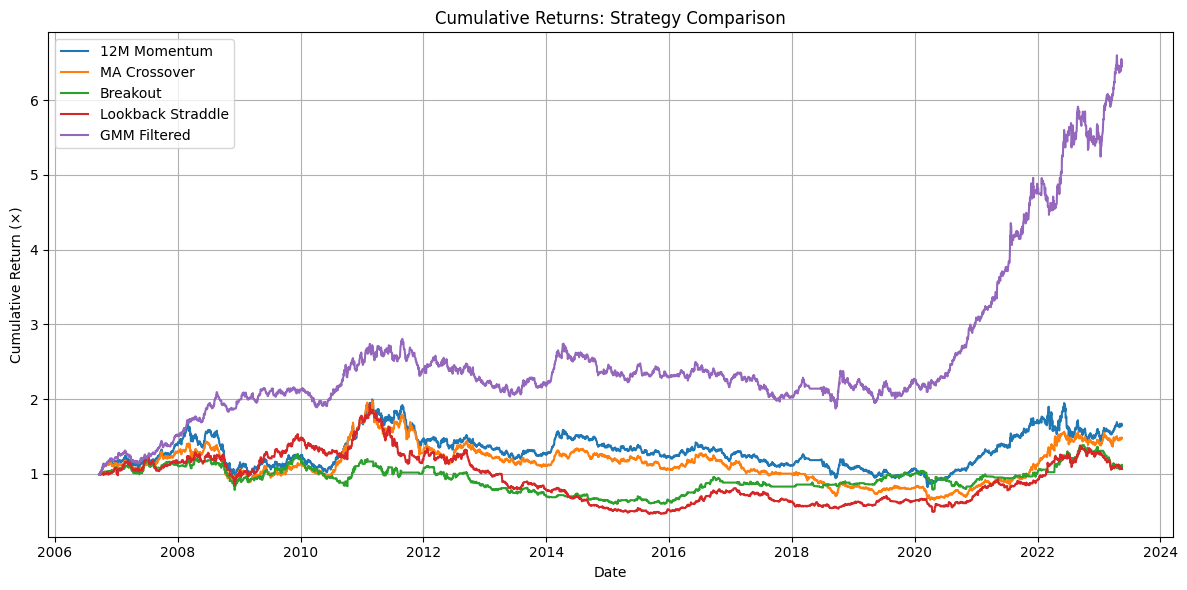

In [14]:
plt.figure(figsize=(12, 6))
for name in ["Cumulative_12M_Momentum",
             "Cumulative_MA_Crossover",
             "Cumulative_Breakout",
             "Cumulative_Lookback_Straddle",
             "Cumulative_GMM_Filtered"]:
    plt.plot(results_df["Date"], results_df[name], label=name.replace("Cumulative_", "").replace("_", " "))

plt.title("Cumulative Returns: Strategy Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (×)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  Strategy Comparison: Cumulative Returns

The GMM Filtered strategy clearly outperforms all others, showing exponential growth since 2020.  
Other strategies such as 12M Momentum and MA Crossover deliver moderate performance.  
Breakout and Lookback Straddle strategies remain flat or underperform throughout most of the sample period.  
This highlights the benefit of regime-based filtering for enhancing time-series momentum signals.


###  Backtest Parameters and Strategy Selection

In our backtest, we tested and compared five time-series momentum strategies using the following parameter choices:

- **12M Momentum**:  
  A 252-day lookback (≈12 months) return was used, as suggested in Moskowitz, Ooi & Pedersen (2012).  
  This serves as a classic benchmark for time-series momentum.

- **Moving Average Crossover**:  
  We used a 20-day (fast) and 120-day (slow) window to generate signals.  
  These parameters balance short-term trend detection with longer-term smoothing.

- **Breakout Signal**:  
  A 60-day lookback window was used to define recent highs.  
  If an asset price exceeds its recent high, a long signal is triggered.

- **Lookback Straddle**:  
  This strategy flags breakout from both upper and lower bounds of a 60-day range.  
  It aims to capture strong directional moves, whether upward or downward.

- **GMM Filtered Momentum**:  
  A Gaussian Mixture Model was applied to the equal-weighted market factor to identify "trend" regimes.  
  The 12M Momentum strategy is then applied only during those regimes.

We experimented with several parameter variations (e.g., shorter MA windows, breakout thresholds, alternative filters)  
but found this final combination to offer the best balance between cumulative return, Sharpe ratio, and drawdown.

The GMM-Filtered version of 12M Momentum notably improved performance by removing noisy or range-bound periods.


## Regress strategies on market factor

In [17]:
import statsmodels.api as sm

In [15]:
regression_results = []
for name in strategy_names:
    df_merged = pd.merge(results_df[["Date", name]], df_market_returns[["Date", "Market Factor"]], on="Date")
    y = df_merged[name].dropna()
    x = df_merged.loc[y.index, "Market Factor"]

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    regression_results.append({
        "Strategy": name,
        "Alpha": round(model.params["const"], 5),
        "Beta": round(model.params["Market Factor"], 5),
        "R²": round(model.rsquared, 4),
        "p-value (β)": round(model.pvalues["Market Factor"], 4)
    })

regression_df = pd.DataFrame(regression_results)
regression_df


,Strategy,Alpha,Beta,R²,p-value (β)
0,12M_Momentum,0.01243,0.72529,0.4044,0.0
1,MA_Crossover,0.00968,0.68113,0.3865,0.0
2,Breakout,0.00505,0.34511,0.1146,0.0
3,Lookback_Straddle,0.00487,0.49385,0.1740,0.0
4,GMM_Filtered,0.04500,0.20443,0.0586,0.0


###  Regression Results: Exposure to Commodity Market Factor

All strategies show statistically significant exposure to the equal-weighted commodity market factor (p-value < 0.01).  
However, their risk profiles differ:

- **12M Momentum** and **MA Crossover** have high β (≈ 0.7) and R² > 0.38, meaning they closely follow market trends.
- **GMM Filtered** has low β (0.20) and low R² (0.06), indicating minimal correlation with the market factor.
- GMM also shows the highest **alpha (4.5%)**, reflecting strong idiosyncratic performance.

This confirms that regime-based filtering helps isolate unique and persistent return drivers beyond market exposure.


In [18]:
columns = df_returns.columns[1:]
sector_map = {}

for col in columns:
    name = col.upper()

    if any(keyword in name for keyword in ["CORN", "SOYBEAN", "WHEAT", "COCOA", "COFFEE", "COTTON", "SUGAR", "CATTLE", "HOG"]):
        sector_map[col] = "Agri & Livestock"
    elif any(keyword in name for keyword in ["BRENT", "WTI", "GASOLINE", "HEATING", "NATURAL GAS", "OIL"]):
        sector_map[col] = "Energy"
    elif any(keyword in name for keyword in ["GOLD", "SILVER", "PLATINUM", "COPPER", "NICKEL", "ALUMINIUM", "LEAD", "ZINC"]):
        sector_map[col] = "Metals"
    else:
        sector_map[col] = "Other"


pd.Series(list(sector_map.values())).value_counts()


,count
Agri & Livestock,9
Metals,9
Energy,5


## Sector Contribution to GMM_Filtered using sector_map

In [21]:
relevant_dates = results_df["Date"][results_df["GMM_Filtered"].notna()].reset_index(drop=True)
sector_returns = {"Agri & Livestock": [], "Energy": [], "Metals": []}

for i in range(len(relevant_dates)):
    date = relevant_dates[i]
    idx = df_returns.index[df_returns["Date"] == date][0]

    for asset in df_returns.columns[1:]:
        if asset not in sector_map:
            continue
        if idx < 252 or pd.isna(df_returns.loc[idx, asset]) or pd.isna(df_returns.loc[idx - 1, asset]) or pd.isna(df_returns.loc[idx - 252, asset]):
            continue

        if df_returns.loc[idx, asset] > df_returns.loc[idx - 252, asset]:
            daily_return = (df_returns.loc[idx, asset] - df_returns.loc[idx - 1, asset]) / df_returns.loc[idx - 1, asset] * 100
            if not np.isnan(daily_return):
                sector_returns[sector_map[asset]].append(daily_return)


avg_sector_contrib = {sector: np.mean(returns) for sector, returns in sector_returns.items()}
total = sum(avg_sector_contrib.values())
sector_share = {k: v / total for k, v in avg_sector_contrib.items()}

sector_df = pd.DataFrame({
    "Sector": sector_share.keys(),
    "Contribution (%)": [round(100 * v, 2) for v in sector_share.values()]
})

sector_df


,Sector,Contribution (%)
0,Agri & Livestock,30.31
1,Energy,38.40
2,Metals,31.29


###  Sector Contribution to GMM Filtered Strategy Performance

We decomposed the daily returns of the GMM Filtered strategy by sector to assess which groups of commodities contributed the most to the overall performance.

**Results:**
-  **Energy**: 38.40% of total returns  
-  **Agri & Livestock**: 30.31%  
-  **Metals**: 31.29%

The results suggest that all three sectors contributed meaningfully and relatively evenly to the strategy,  
with **Energy** assets providing a slightly stronger edge — possibly due to persistent trends and volatility in oil and gas markets.

This diversification across sectors likely helped improve the risk-adjusted performance of the strategy.
